In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def add_time_groups(df, timestamp_col):
    """Add hour and day_type columns to DataFrame."""
    ts = pd.to_datetime(df[timestamp_col].str[:19])  # Just 'YYYY-MM-DDTHH:MM:SS'
    df = df.copy()
    df['hour'] = ts.dt.hour
    df['day_type'] = ts.dt.dayofweek.apply(lambda x: "weekend" if x >= 5 else "weekday")
    return df

def plot_hourly_averages(df, value_col, day_type_filter=None):
    """Plot average values by hour, optionally filtered by day type.
    
    Args:
        df: DataFrame with 'hour' and 'day_type' columns (from add_time_groups)
        value_col: Column name to compute averages for
        day_type_filter: None (both), "weekday", or "weekend"
    """
    if day_type_filter:
        df = df[df['day_type'] == day_type_filter]
    
    hourly_avg = df.groupby('hour')[value_col].mean()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(hourly_avg.index, hourly_avg.values)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel(f'Average {value_col}')
    ax.set_title(f'Average {value_col} by Hour ({day_type_filter or "All Days"})')
    ax.set_xticks(range(24))
    plt.tight_layout()
    return fig, ax

def plot_hourly_comparison(df, value_col):
    """Plot weekday vs weekend averages side by side."""
    hourly_avg = df.groupby(['hour', 'day_type'])[value_col].mean().unstack()
    hourly_avg = hourly_avg.reindex(range(24))  # Fill in missing hours with NaN
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    x = range(24)
    width = 0.35
    
    if 'weekday' in hourly_avg.columns:
        ax.bar([i - width/2 for i in x], hourly_avg['weekday'], width, 
               label='Weekday', color='steelblue')
    if 'weekend' in hourly_avg.columns:
        ax.bar([i + width/2 for i in x], hourly_avg['weekend'], width, 
               label='Weekend', color='coral')
    
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel(f'Average {value_col}')
    ax.set_title(f'Average {value_col} by Hour: Weekday vs Weekend')
    ax.set_xticks(range(24))
    ax.legend()
    plt.tight_layout()
    return fig, ax

                          timestamp      value
0  2024-01-01T00:00:00+00:00 London  54.967142
1  2024-01-01T01:00:00+00:00 London  48.617357
2  2024-01-01T02:00:00+00:00 London  56.476885
3  2024-01-01T03:00:00+00:00 London  65.230299
4  2024-01-01T04:00:00+00:00 London  47.658466
5  2024-01-01T05:00:00+00:00 London  47.658630
6  2024-01-01T06:00:00+00:00 London  65.792128
7  2024-01-01T07:00:00+00:00 London  57.674347
8  2024-01-01T08:00:00+00:00 London  55.305256
9  2024-01-01T09:00:00+00:00 London  85.425600

Total rows: 8761

Sample of summer timestamps:
                             timestamp      value
2184  2024-04-01T00:00:00+01:00 London  27.881381
2185  2024-04-01T01:00:00+01:00 London  65.334337
2186  2024-04-01T02:00:00+01:00 London  35.760428
2187  2024-04-01T03:00:00+01:00 London  47.333477
2188  2024-04-01T04:00:00+01:00 London  45.707556

Sample of winter timestamps:
                          timestamp      value
0  2024-01-01T00:00:00+00:00 London  54.967142
1  2024-01-

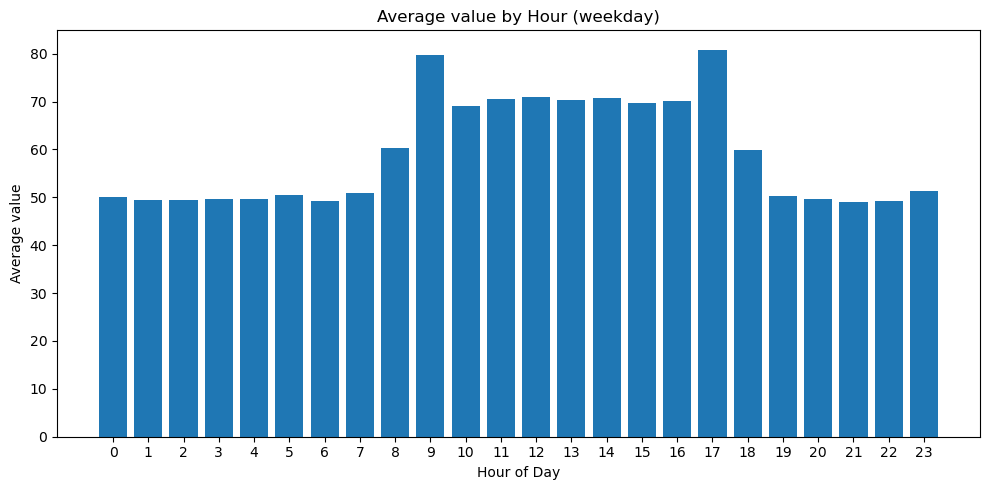

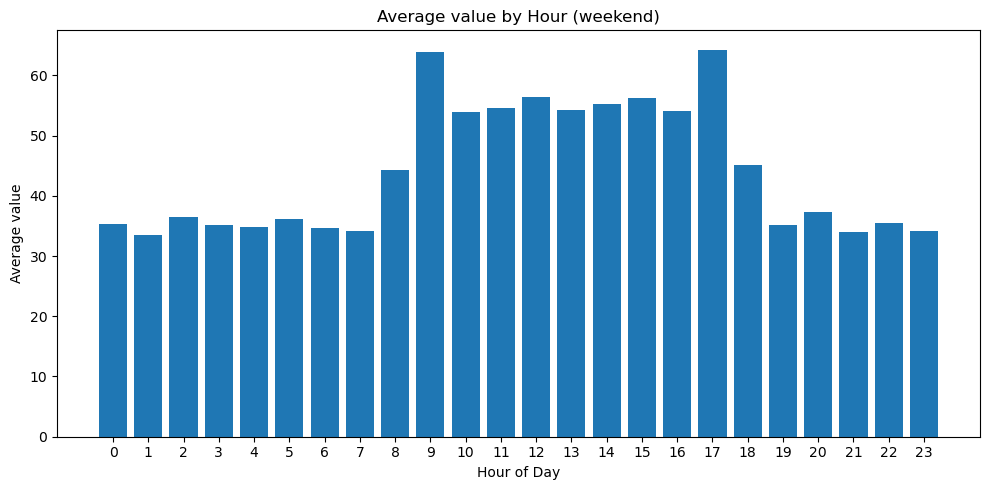

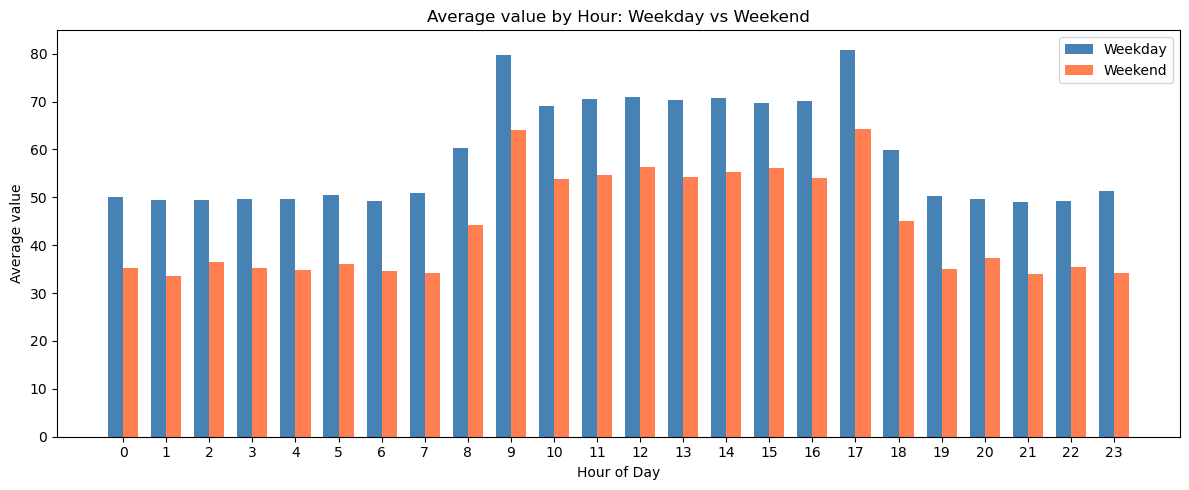

In [18]:
# Sample data
import pandas as pd
import numpy as np

# Generate a year of hourly data
np.random.seed(42)
dates = pd.date_range('2024-01-01', '2024-12-31', freq='h')

# Create realistic-looking timestamps with London timezone
# +00:00 for winter (roughly Nov-Mar), +01:00 for summer (roughly Apr-Oct)
def format_london_timestamp(dt):
    # Simplified BST: April-October = +01:00, otherwise +00:00
    if 4 <= dt.month <= 10:
        offset = '+01:00'
    else:
        offset = '+00:00'
    return dt.strftime('%Y-%m-%dT%H:%M:%S') + offset + ' London'

timestamps = [format_london_timestamp(dt) for dt in dates]

# Generate values with some patterns:
# - Higher during working hours (9-17)
# - Lower on weekends
# - Some random noise
values = []
for dt in dates:
    base = 50
    # Working hours boost
    if 9 <= dt.hour <= 17:
        base += 20
    # Weekend reduction
    if dt.dayofweek >= 5:
        base -= 15
    # Rush hour peaks
    if dt.hour in [8, 9, 17, 18]:
        base += 10
    # Add noise
    value = base + np.random.randn() * 10
    values.append(value)

df = pd.DataFrame({
    'timestamp': timestamps,
    'value': values
})

print(df.head(10))
print(f"\nTotal rows: {len(df)}")
print(f"\nSample of summer timestamps:")
print(df[df['timestamp'].str.contains(r'\+01:00')].head())
print(f"\nSample of winter timestamps:")
print(df[df['timestamp'].str.contains(r'\+00:00')].head())

print(df.head())

# Add time grouping columns
df = add_time_groups(df, 'timestamp')

# Plot just weekdays
fig, ax = plot_hourly_averages(df, 'value', day_type_filter='weekday')
plt.show()

# Plot just weekends
fig, ax = plot_hourly_averages(df, 'value', day_type_filter='weekend')
plt.show()

# Compare both side by side
fig, ax = plot_hourly_comparison(df, 'value')
plt.show()

In [5]:
def get_hourly_summary(df, value_col):
    """Get summary statistics by hour and day type."""
    summary = df.groupby(['day_type', 'hour'])[value_col].agg(
        ['mean', 'std', 'count', 'min', 'max']
    ).reset_index()
    return summary

# Export to Excel
summary = get_hourly_summary(df, 'value')
summary.to_excel('hourly_summary.xlsx', index=False)